# Compare Levmar vs GSL engines (Single exponential)

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import prettyprint
import re
import numpy as np
from glob import glob
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from stuff import Simulation
from validation import CrossValidation
from image import Image

## Model configuration

In [2]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/for_marc/demo_marc.conf')

In [3]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/for_marc/demo_marc_Exp.py')

In [4]:
base_dir = '/home/aalvarez/Work/Data/for_marc/'
frames = sorted(glob(os.path.join(base_dir, 'images/T+10.0*_02_*.fits')))
nframes = len(frames)
print(f'Number of frames used: {nframes}')

Number of frames used: 5


## Levmar run

In [5]:
levmar_dir = os.path.join(base_dir, 'EXP', 'LEVMAR')
levmar_log = open(os.path.join(levmar_dir, 'logging.log')).read()

In [6]:
rengine = re.search('Using engine \w+', levmar_log)
levmar_log[rengine.start():rengine.end()]

'Using engine levmar'

In [7]:
re.findall('Elapsed: \d+:\d+:\d+', levmar_log)[-1]

'Elapsed: 00:00:14'

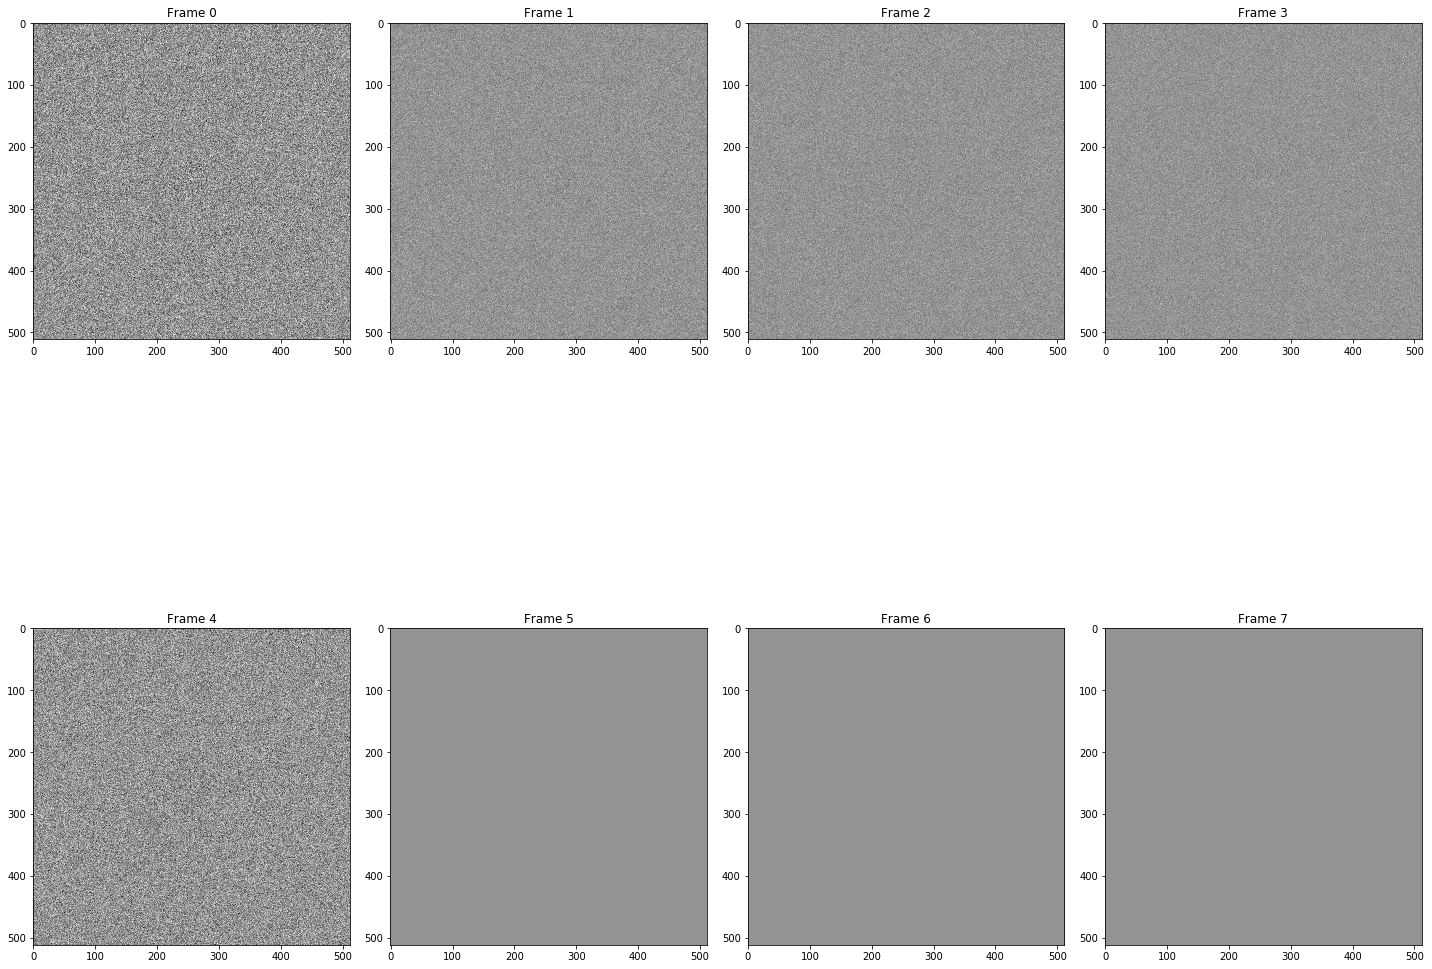

In [8]:
cmap = plt.get_cmap('Greys')
norm = colors.SymLogNorm(1)

ncols = 4
nrows = int(np.ceil(nframes / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        if frame >= nframes:
            frame_data = np.zeros(frame_data.shape)
        else:
            frame_data = fits.open(os.path.join(levmar_dir, f'_residual_{frame}.fits'))[0].data
        axes[j, i].set_title(f'Frame {frame}')
        axes[j, i].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## GSL run

In [9]:
gsl_dir = '/home/aalvarez/Work/Data/for_marc/EXP/GSL/'
gsl_log = open(os.path.join(gsl_dir, 'logging.log')).read()

In [10]:
rengine = re.search('Using engine \w+', gsl_log)
gsl_log[rengine.start():rengine.end()]

'Using engine GSL'

In [11]:
re.findall('Elapsed: \d+:\d+:\d+', gsl_log)[-1]

'Elapsed: 00:00:23'

First approach takes longer. May be possible to play with the parameters?

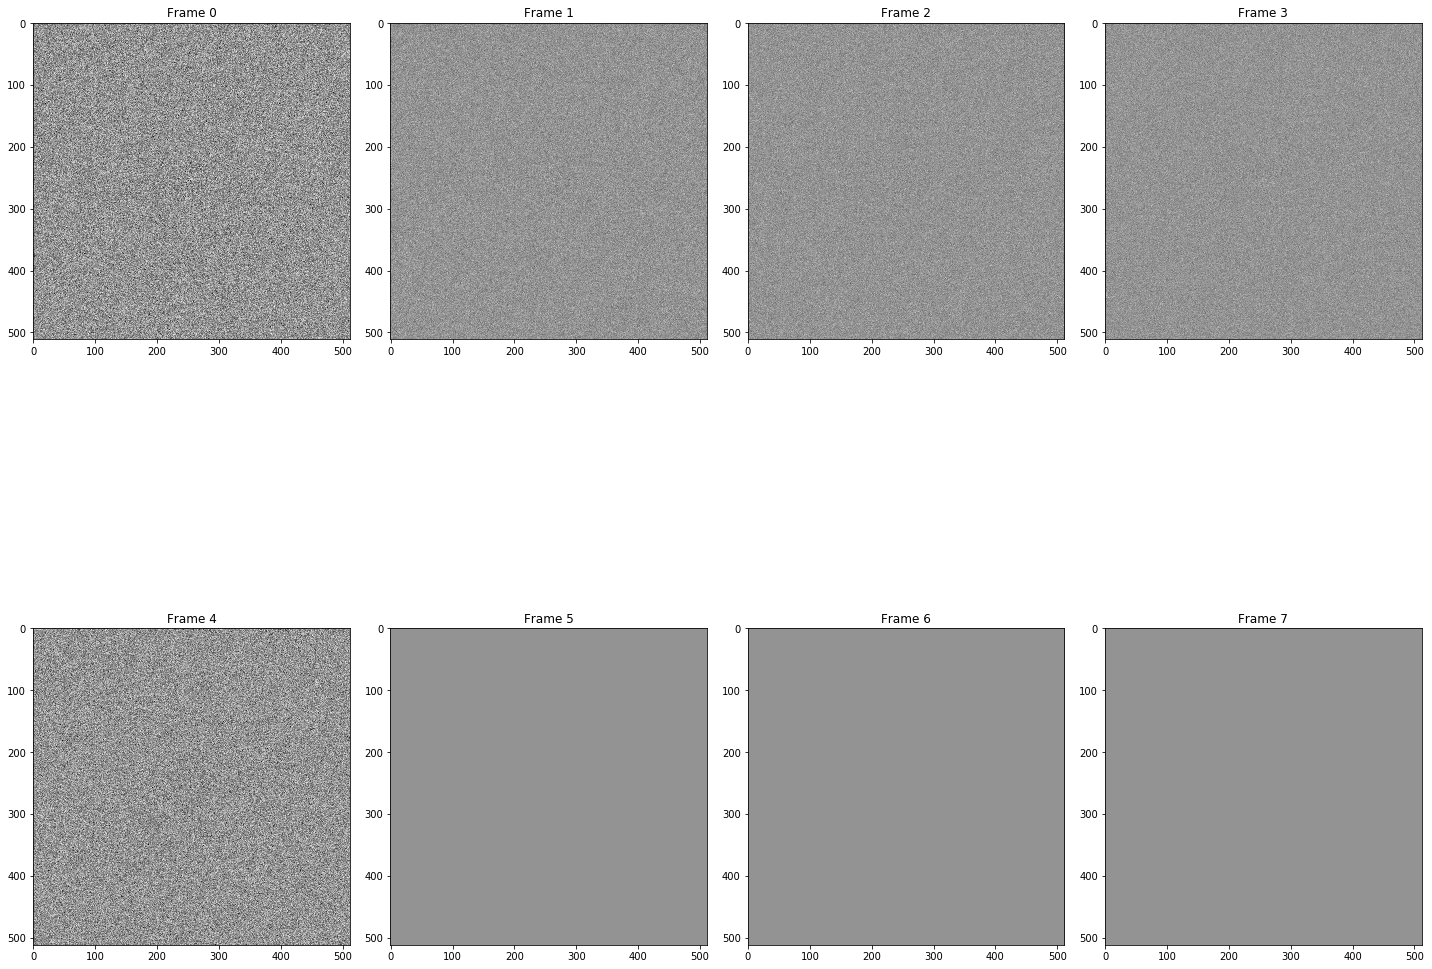

In [12]:
fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        if frame >= nframes:
            frame_data = np.zeros(frame_data.shape)
        else:
            frame_data = fits.open(os.path.join(gsl_dir, f'_residual_{frame}.fits'))[0].data
        axes[j, i].set_title(f'Frame {frame}')
        axes[j, i].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## Compare

/home/aalvarez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


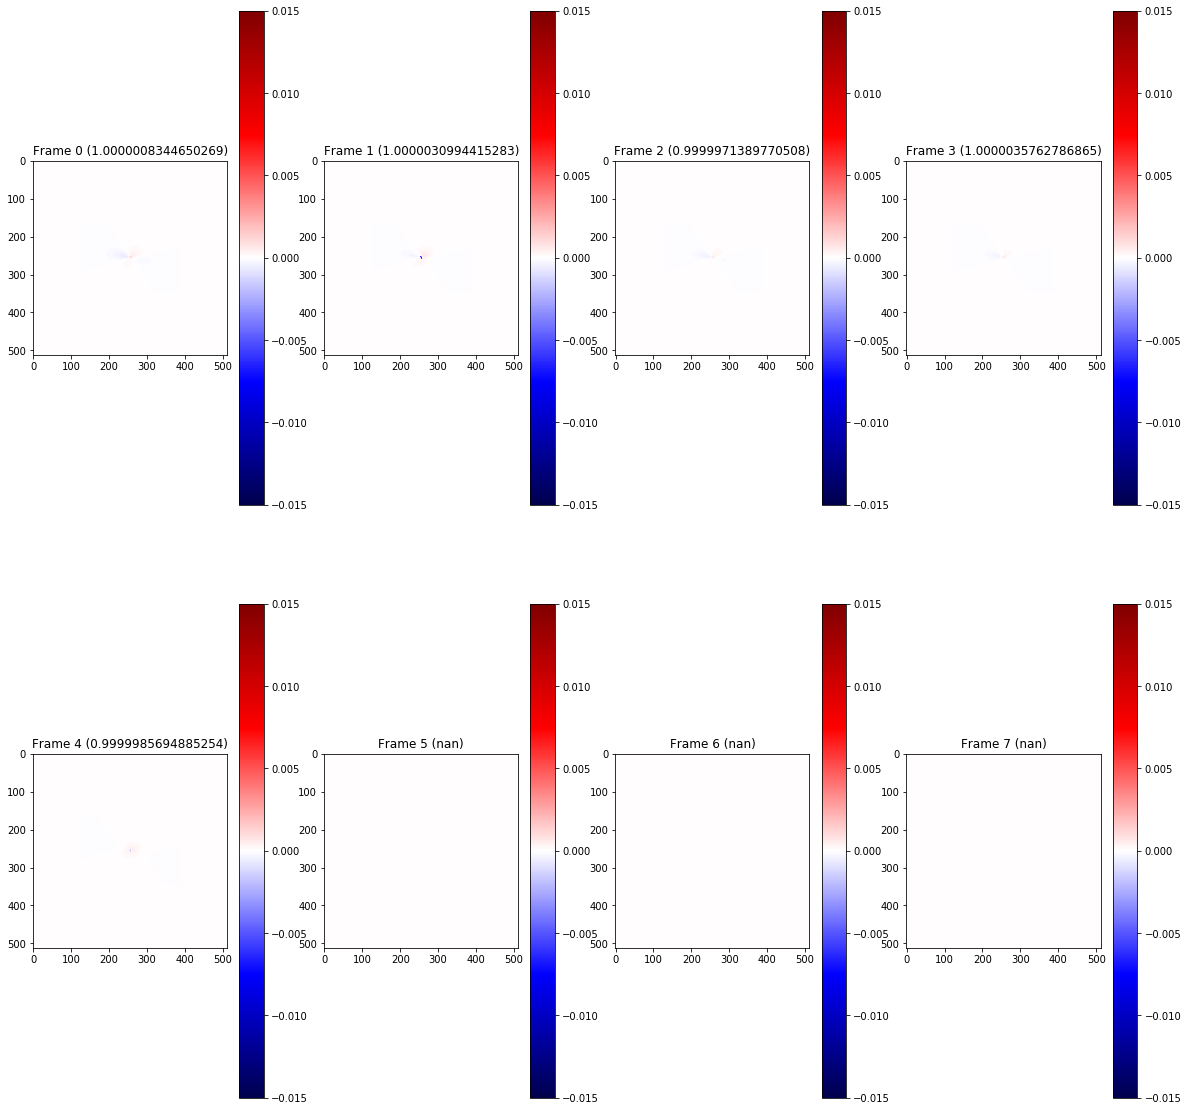

In [13]:
fig, axes = plt.subplots(nrows, ncols, figsize=(20,20))
diff_norm = colors.Normalize(0.015,-0.015)
levmar_total_residual = 0
gsl_total_residual = 0
first_levmar = None
first_gsl = None

for i in range(ncols):
    for j in range(nrows):
        frame = i + j * 4
        if frame >= nframes:
            levmar_residual = gsl_residual = np.zeros(levmar_residual.shape)
        else:
            levmar_residual = fits.open(os.path.join(levmar_dir, f'_residual_{frame}.fits'))[0].data
            gsl_residual = fits.open(os.path.join(gsl_dir, f'_residual_{frame}.fits'))[0].data
        if first_levmar is None:
            first_levmar = levmar_residual
            first_gsl = gsl_residual
            
        levmar_total_residual += np.abs(levmar_residual).sum()
        gsl_total_residual += np.abs(gsl_residual).sum()
        ratio = np.abs(gsl_residual).sum() / np.abs(levmar_residual).sum()
        axes[j, i].set_title(f'Frame {frame} ({ratio})')
        im = axes[j, i].imshow(levmar_residual-gsl_residual, cmap=plt.get_cmap('seismic'), norm=diff_norm)
        plt.colorbar(im, ax=axes[j, i])

#plt.tight_layout()
plt.show()

In [14]:
print(gsl_total_residual/levmar_total_residual)

1.0000003063469791


Detailed:

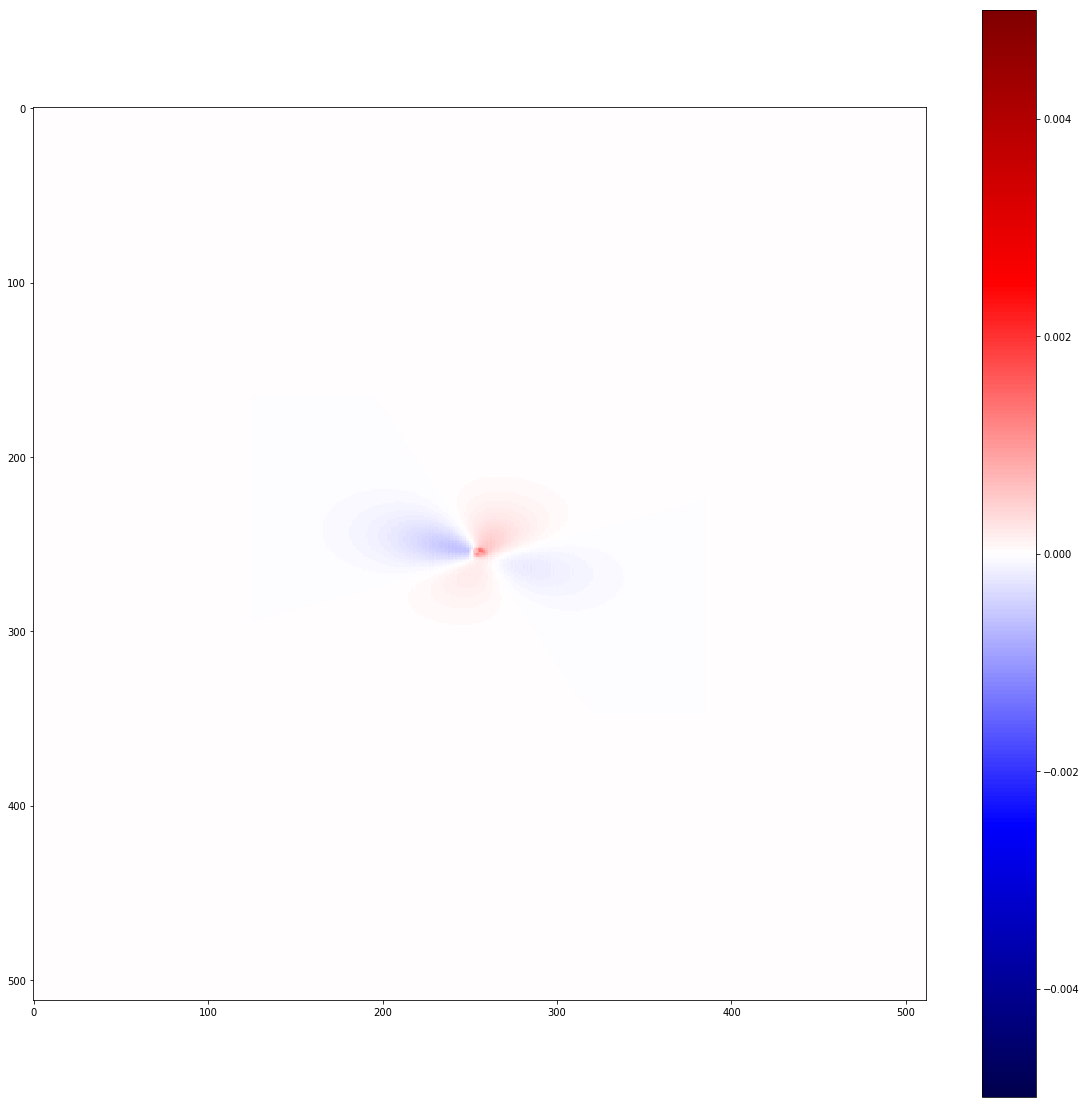

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(first_levmar-first_gsl, cmap=plt.get_cmap('seismic'), norm=colors.Normalize(0.005,-0.005))
plt.colorbar()
plt.show()

Even though the residuals looks kind of similar, they deffinitely are not. Oddly, it seems like there is some kind of simmetry, or rotation. It does not look random to me.

## Compare catalogs

In [18]:
levmar_cat = Table.read(os.path.join(levmar_dir, 'catalogue.fits'))
gsl_cat = Table.read(os.path.join(gsl_dir, 'catalogue.fits'))

In [19]:
levmar_cat[['x_g', 'y_g', 'rad_g', 'angle_g', 'flux_g']]

x_g,y_g,rad_g,angle_g,flux_g
float64,float64,float64,float64,float64
254.54766845703125,254.53927612304688,7.247878551483154,-5.896193981170654,1143.8682861328125


In [20]:
gsl_cat[['x_g', 'y_g', 'rad_g', 'angle_g', 'flux_g']]

x_g,y_g,rad_g,angle_g,flux_g
float64,float64,float64,float64,float64
254.5545196533203,254.53897094726562,7.244154930114746,-5.874083518981934,1143.72021484375


In [21]:
levmar_cat[['x_g_err', 'y_g_err', 'rad_g_err', 'angle_g_err', 'flux_g_err']]

x_g_err,y_g_err,rad_g_err,angle_g_err,flux_g_err
float64,float64,float64,float64,float64
0.03088225983083248,0.017656449228525162,99.0,99.0,6.461190700531006


In [22]:
gsl_cat[['x_g_err', 'y_g_err', 'rad_g_err', 'angle_g_err', 'flux_g_err']]

x_g_err,y_g_err,rad_g_err,angle_g_err,flux_g_err
float64,float64,float64,float64,float64
0.021650096401572227,0.017557796090841293,99.0,99.0,6.501552104949951
